In [4]:
import pandas as pd
import pandas_datareader.data as reader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from keras.callbacks import EarlyStopping
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

ModuleNotFoundError: No module named 'pandas_datareader'

### Web에서 Data 가져오기
pandas `DataReader` 를 사용해 삼성전자 `005930.KS` 의 5년치 주가 정보 로딩

In [ ]:
data = reader.DataReader('005930.KS', 'yahoo', '2015.02.01', '2020.1.31')
print(data.info())

In [ ]:
data.head()

### Data Normalization
학습 효율을 높이기 위해 데이터를 0 ~ 1 사이의 값으로 정규화


`MinMaxScaler` 를 사용한다. 이때 `train_data` 와 `test_data` 는 같은 `scaler` 를 사용해 정규화해야 한다.

In [2]:
data_set = data[['Adj Close']].values
scaler = MinMaxScaler()
nomalized_data_set = scaler.fit_transform(data_set)
nomalized_data_set

NameError: name 'data' is not defined

### Window 생성
LSTM 학습을 위해 window 생성, `window_len=5` 이면 5일치 데이터를 바탕으로 다음날 데이터를 예측

In [8]:
window_len = 5
sequence_length = window_len + 1
result = []
date_idx = []

for index in range(len(nomalized_data_set) - sequence_length):
    result.append(nomalized_data_set[index: index + sequence_length])
    date_idx.append(data.index[index + sequence_length-1])
    
# result = [data_set[i:i+sequence_length] for i in range(len(date_set) - sequence_length)]
result = np.array(result)

In [13]:
print(result[0])

[[0.00080331]
 [0.00079708]
 [0.00077524]
 [0.00077212]
 [0.00081579]
 [0.00088753]]


In [20]:
train_ratio = 0.75
train_num = int(round(result.shape[0] * train_ratio))
train = result[:train_num, :]
np.random.seed(10)
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = result[:train_num, -1]

x_test = result[train_num:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[train_num:, -1]

x_train.shape, x_test.shape

((906, 5, 1), (302, 5, 1))

### LSTM 모델 생성
`Sequential()` 모델을 사용해 LSTM layer 2개와 Dense layer 1개를 연결

회귀 문제이기 때문에 출력층 activation function은 `linear` (선형),  loss function은 `mean squred error` (평균 제곱 오류) 를 사용

최적화 함수는 일반적으로 가장 많이 사용되는 `adam`을 사용

In [21]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 5, 32)             4352      
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 29,249
Trainable params: 29,249
Non-trainable params: 0
_________________________________________________________________


### 모델 학습
한 번에 `batch_size` 만큼 학습시키며 `epochs` 만큼 반복학습

`EarlyStopping` callback을 사용해 `val_loss` 의 개선이 없을 경우 학습 조기 종료

In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
training_result = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                            batch_size=2, epochs=150, callbacks=[early_stop])

Train on 906 samples, validate on 302 samples
Epoch 1/150
906/906 [==============================] - 48s 53ms/step - loss: 0.0058 - val_loss: 0.0019
Epoch 2/150
906/906 [==============================] - 31s 35ms/step - loss: 7.3504e-04 - val_loss: 0.0014
Epoch 3/150
906/906 [==============================] - 33s 36ms/step - loss: 8.1750e-04 - val_loss: 4.6285e-04
Epoch 4/150
906/906 [==============================] - 37s 41ms/step - loss: 7.3423e-04 - val_loss: 0.0013
Epoch 5/150
906/906 [==============================] - 34s 38ms/step - loss: 6.1812e-04 - val_loss: 0.0077
Epoch 6/150
906/906 [==============================] - 37s 41ms/step - loss: 7.2684e-04 - val_loss: 0.0014
Epoch 7/150
906/906 [==============================] - 36s 40ms/step - loss: 7.6271e-04 - val_loss: 0.0157
Epoch 8/150
906/906 [==============================] - 32s 36ms/step - loss: 5.9458e-04 - val_loss: 3.9445e-04
Epoch 9/150
906/906 [==============================] - 33s 36ms/step - loss: 5.3962e-04 - val_

### 학습된 모델을 통해 예측한 주식 결과 출력
`inverse_transform` 을 사용해 원래값으로 출력 가능

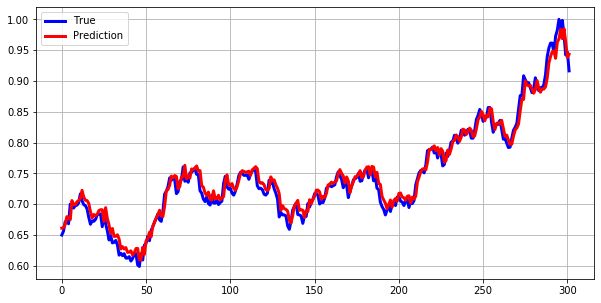

In [23]:
pred = model.predict(x_test)

plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.grid'] = True 

plt.plot(y_test, color='b', label='True')
plt.plot(pred, color='r', label='Prediction')
plt.legend()
plt.show()

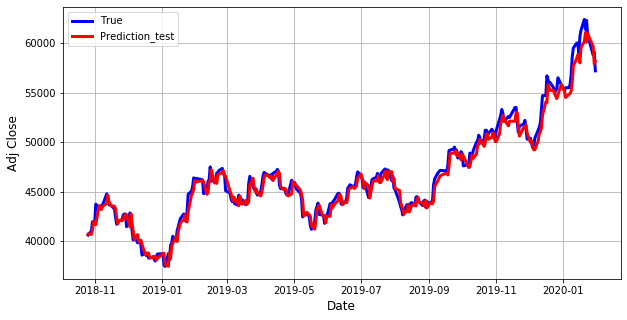

In [19]:
idx = date_idx[train_num:]
test_pred_inv = scaler.inverse_transform(pred)

plt.plot(idx, data['Adj Close'][idx], label='True', color='b')
plt.plot(idx, test_pred_inv, label='Prediction_test', color='r')
plt.ylabel('Adj Close', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend()
plt.show()

### 학습 과정 출력
`loss` 와 `val_loss` 지표를 통해 과적합 유무 등을 판단할 수 있다.

회귀 문제이기 때문에 `acc` 지표는 사용할 수 없다.

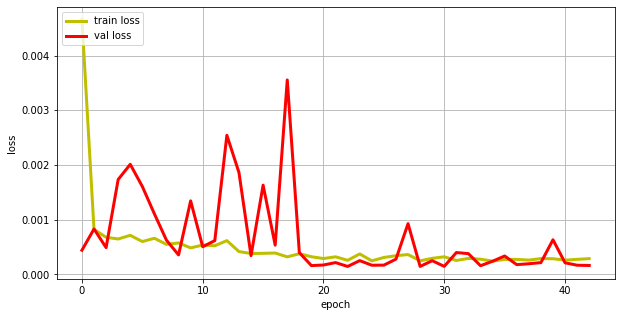

In [10]:
plt.plot(training_result.history['loss'], 'y', label='train loss')
plt.plot(training_result.history['val_loss'], 'r', label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper left')

plt.show()

In [11]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=2)
print('loss : ' + str(loss_and_metrics))

302/302 [==============================] - 0s 936us/step
loss : 0.00016192974178707027


### Model 저장하기

In [39]:
model.save('stock_lstm_model.h5')